# Esercitazione 4

In [15]:
def logistic(z):
    return 1/(1+m.e**(-z))

def log_loss(X, y, a, a0):
    ll_sum = 0
    for i in range(X.shape[1]):
        x = X[:,i:i+1]
        guess = logistic(a.T.dot(x)[0][0]+a0)
        ll_sum += y[i]*m.log10(guess) + (1-y[i])*m.log10(1-guess)
    return - ll_sum

def logistic_der(X, y, a, a0 ):
    g = np.zeros(a.shape)
    g0 = 0
        
    for i in range(X.shape[1]):
        x = X[:,i:i+1]
        g += x*(logistic(a.T.dot(x) + a0 ) -y[i])
        g0 += logistic(a.T.dot(x) + a0 ) -y[i]  
    
    return g, g0

def logistic_dg( X, y, step, eps, max_iter):
    curr_a = np.zeros( (X.shape[0], 1) )
    curr_a0 = 0
    
    for t in range(max_iter):
        curr_grad, curr_grad0 = logistic_der(X, y, curr_a, curr_a0)
        
        next_a  = curr_a - step*curr_grad
        next_a0 = curr_a0 - step*curr_grad0
        
        curr_a, curr_a0 = next_a, next_a0
    print('iter:', t)
    return curr_a, curr_a0

## Esercizio 1 (Discesa del gradiente stocastico)

Riprendiamo l'algoritmo della *discesa del gradiente*

![gd_alg](gd_alg.png)

se la funzione $f$ ha questa forma

$$
f(z) = \sum_{i=1}^{n} f_i(z)
$$

(ovvero il caso della `log_loss`), può tornare utile il più efficiente algoritmo della *discesa del gradiente stocastico*

![gd_alg](sgd_alg.png)

Che converge al minimo se `step` è una funzione decrescente in `t` tale che

$$
\sum_{t=1}^{+\infty} step(t) < +\infty
$$

Modificare le funzioni riportate nella prima parte del documento in modo da implementare l'algoritmo di discesa del gradiente stocastico


### Soluzione

Aggiungere la/e funzioni modificate nel seguente codice

iter: 999


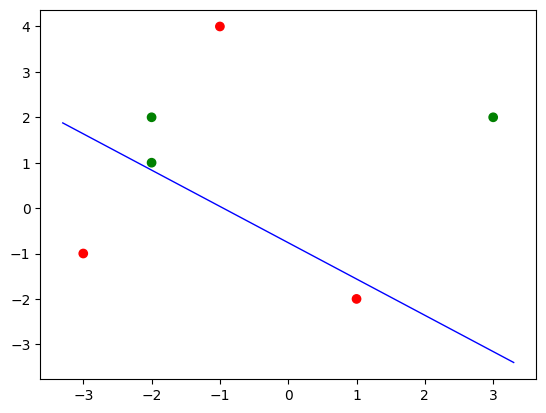

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import math as m
import random as rn

def logistic_der(X, y, a, a0 ):
    i = rn.randint(0, X.shape[1]-1)
    x = X[:,i:i+1]
        
    g = x*(logistic(a.T.dot(x) + a0 ) -y[i])
    g0 = logistic(a.T.dot(x) + a0 ) -y[i]  
    
    return g, g0


def logistic_dg( X, y, step, eps, max_iter):
    curr_a = np.zeros( (X.shape[0], 1) )
    curr_a0 = 0
    
    for t in range(max_iter):
        curr_grad, curr_grad0 = logistic_der(X, y, curr_a, curr_a0)
        
        next_a  = curr_a - step(t)*curr_grad
        next_a0 = curr_a0 - step(t)*curr_grad0
        
        curr_a, curr_a0 = next_a, next_a0
    print('iter:', t)
    return curr_a, curr_a0
    
X = [ (3, 2), (-1, 4), (-2, 1), (1,-2), (-3,-1), (-2,2) ]
y = [1,0,1,0,0,1]

X = np.array(X).T

plt.scatter(X[0], X[1], c=['g' if e == 1 else 'r' for e in y])

ax = plt.gca()
xlim_left, xlim_right = ax.get_xlim()
ylim_bottom, ylim_top = ax.get_ylim()

def f(x):
    return 1/(x+1)

a, a0 = logistic_dg(X, y, step=f, eps=0.01, max_iter=1000)

a0 = a0[0][0]

plt.plot( ( xlim_left, xlim_right) , [ (-x*a[0][0]-a0)/a[1][0] for x in  (xlim_left, xlim_right) ],\
             linewidth=1, c = 'b', zorder=0 )

## Esercizio 3

Sperimentare l'algoritmo `DBSCAN` con  i punti del file `walk.shp`. Inoltre modificare l'algoritmo in modo che elimini dal dataframe tutti i punti di ogni cluster tranne quello che è più vicino al centroide del cluster (vedere la documentazione della libreria shapely; potrebbe far comodo usare il tipo `MultiPoint` della suddetta libreria).

### Soluzione

In [18]:
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, MultiPoint
from os.path import join

def dbscan(punti_gdf, eps = 4, min_pts = 4):
    n = punti_gdf.shape[0]
    c = -1
    labels = ['None']*n
    
    for i, p in punti_gdf.iterrows():
        if labels[i] != 'None':
            continue
        
        N = punti_gdf[ punti_gdf.distance(p['geometry']) < eps ]
        
        if len(N) < min_pts:
            labels[i] = 'Noise'
            continue
    
        c += 1
        labels[i] = str(c)
        
        S = set(list(N.index)) - set([i])
        
        while len(S) > 0:
            q = S.pop()
            if labels[q] == 'Noise':
                labels[q] = str(c)
            if labels[q] != 'None':
                continue
            q_geom =  punti_gdf.loc[q, 'geometry']
            N = punti_gdf[ punti_gdf.distance(q_geom) < eps ]
            labels[q] = str(c)
            if len(N) < min_pts:
                continue
            S = S.union(set(list(N.index)) - set([q]))
            
    punti_gdf['label'] = labels
    
    return c+1 # numero di cluster

Numero di cluster: 6


<Axes: >

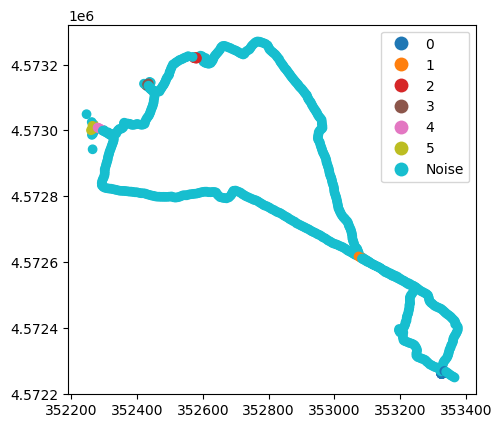

In [19]:
punti_gdf = gpd.read_file(join('data','walk.shp'))

print('Numero di cluster:', dbscan(punti_gdf, 5, 4) )

punti_gdf.plot('label', legend=True)

Per risolvere il problema:

1. filtrare dal geodataframe i punti di ogni cluster p.e. in questo modo  

In [21]:
C2 = punti_gdf[ punti_gdf['label'] == '2' ]
C2

,FID,geometry,label
297,297,POINT Z (352582.146 4573218.446 13.000),2
298,298,POINT Z (352578.618 4573217.963 13.000),2
299,299,POINT Z (352577.706 4573222.535 13.000),2
300,300,POINT Z (352572.703 4573219.527 13.000),2
301,301,POINT Z (352576.052 4573219.459 13.000),2
302,302,POINT Z (352581.048 4573222.134 13.000),2
303,303,POINT Z (352574.517 4573222.266 13.000),2


2. Inserire tutti i punti in un MultiPoint `mp`
3. Calcolare il centroide di `mp` con il metodi `centroid`
4. Trovare l'indice in `C2` del punto più vicino al centroide
5. Eliminare tutti gli altri punti di `C2` dal geodataframe di partenza